In [22]:
import cv2
import numpy as np
from numpy.core.defchararray import join,mod
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A
import requests

from io import BytesIO

from PIL import Image

import random
import torch

from tqdm.notebook import tqdm

import torch.nn as nn

from torch._C import device

import torch.optim as optim

import torch.autograd.grad_mode as grad_mode

from torch.autograd import Function as F

from torch.utils.data import Dataset, DataLoader

import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torchvision.models.detection.rpn import AnchorGenerator


In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
device

device(type='cuda')

In [25]:
def imgshow(number , title=None, size=5):
    
    root = "/kaggle/input/guns-object-detection/"
    image = cv2.imread(root + "Images/" + str(number) + ".jpeg")

    file = open(root+"Labels/" + str(number) + ".txt", "r")
    txt_data = file.readlines()
    file.close()

    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0] , indices[1])
        end_point = (indices[2], indices[3])

        cv2.rectangle(image , start_point, end_point, (0,0,255), 2)

    aspect_ratio = image.shape[0]/image.shape[1]
    plt.figure(figsize = (size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title+txt_data[0])
    plt.axis('off')
    plt.show()
    

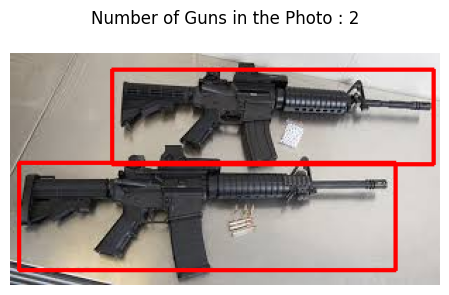

In [26]:
imgshow(119,title = "Number of Guns in the Photo : ")

In [27]:
import os

In [44]:
class Gun_Data(Dataset):
    def __init__(self, root):
        self.image_path = root+"Images/"
        self.labels_path = root+"Labels/"

        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):
        image_path = os.path.join(self.image_path , str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).permute(2,0,1)

        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path, str(label_name))

        with open(label_path,"r") as label_file:
            l_count = int(label_file.readline())
            box=[]
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))
        target = {}
        area=[]
        labels=[]

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)

        return img_res, target

    def __len__(self):
        return len(self.img_name)
            

        

In [45]:
class Model:
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)

        in_features = model.roi_heads.box_predictor.cls_score.in_features

        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)

        return model

    def compiler(self, optimizer):
        self.optimizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)

            train_loss = 0
            self.model.train()

            for img, target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())

                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                train_loss += loss
                
            print(f"Epoch : {epoch+1} | Train loss : {train_loss}")

In [46]:
from torch.utils.data import random_split

In [47]:
rcnn = Model(2)

model = rcnn.model

optimizer = optim.Adam(model.parameters() , lr = 0.0001)

num_epoch = 30

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Gun_Data("/kaggle/input/guns-object-detection/")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset , val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset , batch_size=3, shuffle = True, num_workers=0, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset , batch_size=3, shuffle = False, num_workers=0, collate_fn = collate_fn)



In [48]:
rcnn.train(train_loader , val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 1 | Train loss : 22.92591094970703
Epoch : 2 | Train loss : 17.32083511352539
Epoch : 3 | Train loss : 14.375556945800781
Epoch : 4 | Train loss : 12.662276268005371
Epoch : 5 | Train loss : 9.786249160766602
Epoch : 6 | Train loss : 9.218161582946777
Epoch : 7 | Train loss : 9.322964668273926
Epoch : 8 | Train loss : 7.672805309295654
Epoch : 9 | Train loss : 6.64816951751709
Epoch : 10 | Train loss : 6.738777160644531
Epoch : 11 | Train loss : 6.032129287719727
Epoch : 12 | Train loss : 5.6417155265808105
Epoch : 13 | Train loss : 5.255024433135986
Epoch : 14 | Train loss : 4.8437957763671875
Epoch : 15 | Train loss : 4.596042156219482
Epoch : 16 | Train loss : 4.676364421844482
Epoch : 17 | Train loss : 4.38149356842041
Epoch : 18 | Train loss : 4.108223915100098
Epoch : 19 | Train loss : 3.7926559448242188
Epoch : 20 | Train loss : 3.7342782020568848
Epoch : 21 | Train loss : 3.592132091522217
Epoch : 22 | Train loss : 3.8748056888580322
Epoch : 23 | Train loss : 3.85220193

In [49]:
def test (data, number=random.randint(1,334)):
    img,target = data[number]
    model.eval()

    predictions = model([img])

    predictions = [{k:v.to(device) for k,v in t.items()} for t in predictions]

    return predictions, target, img

In [50]:
def apply_nms(orig_predictions , iou_threshold = None):
    keep = torchvision.ops.nms(orig_predictions["boxes"], orig_predictions["scores"] , iou_threshold)
    
    final_predictions = orig_predictions
    final_predictions["boxes"] = final_predictions["boxes"][keep]
    final_predictions["scores"] = final_predictions["scores"][keep]
    final_predictions["labels"] = final_predictions["labels"][keep]

    return final_predictions

In [51]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [52]:
def plot_img_box(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img) , cv2.COLOR_RGB2BGR)

    for box in target["boxes"]:
        x,y,width,height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width), int(y+height)), (0,0,255) , 2)

    aspect_ratio = img_cv.shape[0]/img_cv.shape[1]

    plt.figure(figsize = (size+aspect_ratio , size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

In [53]:
predictions, target , img = test(dataset, number=10)

In [57]:
nms_prediction = apply_nms(predictions[0] , iou_threshold = 0.7)

In [63]:
nms_prediction

{'boxes': tensor([[ 14.7735,   8.2253,  67.5086,  56.8758],
         [126.5021,  25.6051, 149.0408,  58.8424]], device='cuda:0',
        grad_fn=<IndexBackward0>),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9991, 0.9990], device='cuda:0', grad_fn=<IndexBackward0>)}

In [60]:
from torchvision import transforms as torchtrans

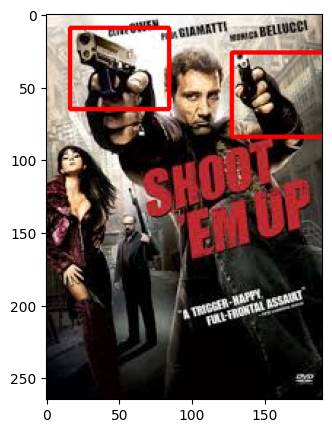

In [61]:
plot_img_box(torch_to_pil(img), target)

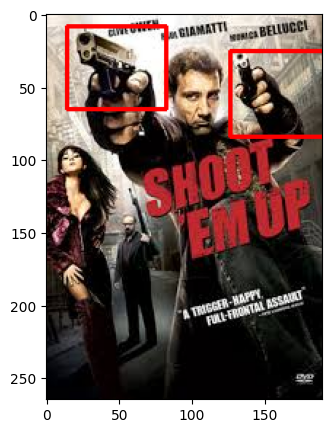

In [62]:
plot_img_box(torch_to_pil(img), nms_prediction)